In [255]:
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
from pathlib import Path
import shutil
import pandas as pd
import xml.etree.ElementTree as ET
from typing import Dict, List, Tuple

# utils

In [260]:
def read_yolo_annotation(annotation_path, target_class=None):
    """
    Read YOLO format annotation file
    Returns list of [label, center_x, center_y, width, height]
    """
    annotations = []
    with open(annotation_path, 'r') as f:
        for line in f:
            # Convert string to numbers
            label, *box = map(float, line.strip().split())
            if len(box) == 4:
                x_center, y_center, width, height = box
            else:
                box = np.array(box).reshape((-1,2))
                x_min, y_min = box.min(axis=0)
                x_max, y_max = box.max(axis=0)
                x_center = x_min + (x_max - x_min) / 2
                y_center = y_min + (y_max - y_min) / 2
                width = x_max - x_min
                height = y_max - y_min
            if target_class is not None and label not in target_class:
                continue
            annotations.append([int(label), x_center, y_center, width, height])
    return annotations

def yolo_to_pixel_coords(yolo_box, image_width, image_height):
    """
    Convert YOLO format bounding box to pixel coordinates
    Returns [x_min, y_min, x_max, y_max]
    """
    x_center, y_center, width, height = yolo_box[1:5]
    
    # Convert normalized coordinates to pixel values
    x_center = x_center * image_width
    y_center = y_center * image_height
    width = width * image_width
    height = height * image_height
    
    # Calculate box corners
    x_min = int(x_center - width/2)
    y_min = int(y_center - height/2)
    x_max = int(x_center + width/2)
    y_max = int(y_center + height/2)
    
    return [x_min, y_min, x_max, y_max]

def visualize_annotations(image_path, annotation_path, target_class=None, figsize=(7,4), line_width=1):
    """
    Visualize YOLO annotations on the image
    """
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get image dimensions
    height, width = image.shape[:2]
    
    # Read annotations
    annotations = read_yolo_annotation(annotation_path, target_class=target_class)
    
    # Colors for different classes (you can modify this)
    colors = np.random.randint(0, 255, size=(100, 3))
    
    # Draw each bounding box
    for ann in annotations:
        label = ann[0]
        box = yolo_to_pixel_coords(ann, width, height)
        # color = tuple(map(int, colors[label]))
        color = (255,0,0)
        
        # Draw rectangle
        cv2.rectangle(image, 
                     (box[0], box[1]), 
                     (box[2], box[3]), 
                     color, 
                     line_width)
        
        # Add label text
        cv2.putText(image, 
                    f'{label}', 
                    (box[0], box[1]), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    color, 
                    line_width)
    
    # Display using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')


In [240]:


def filter_annotations(input_dir, output_dir, target_labels, file_extension='.txt'):
    """
    Filter YOLO annotation files by keeping only specified target labels.
    
    Args:
        input_dir (str): Path to directory containing annotation files
        output_dir (str): Path to directory where filtered annotations will be saved
        target_labels (list): List of label indices to keep
        file_extension (str): Extension of annotation files (default: '.txt')
    """
    # Create output directory if it doesn't exist
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Convert target labels to set for faster lookup
    target_labels = set(target_labels)
    
    # Counter for statistics
    total_files = 0
    total_boxes = 0
    kept_boxes = 0
    
    # Process each annotation file
    for ann_file in Path(input_dir).glob(f'*{file_extension}'):
        filtered_annotations = []
        
        # Read annotations
        with ann_file.open('r') as f:
            annotations = f.readlines()
        
        # Filter annotations
        for ann in annotations:
            try:
                label, *box = map(float, ann.strip().split())
                label = int(label)
                if label in target_labels:
                    if len(box) != 4:
                        box = np.array(box).reshape((-1,2))
                        x_min, y_min = box.min(axis=0)
                        x_max, y_max = box.max(axis=0)
                        x_center = x_min + (x_max - x_min) / 2
                        y_center = y_min + (y_max - y_min) / 2
                        width = x_max - x_min
                        height = y_max - y_min
                        ann_new = ' '.join(['0', str(x_center), str(y_center), str(width), str(height)]) + '\n'
                    else:
                        ann_new = '0 ' + ann.split(sep=' ', maxsplit=1)[-1]
                    # if float(ann.split()[-2]) > 0.2:
                    #     print(ann_file)
                    filtered_annotations.append(ann_new)
                    kept_boxes += 1
                total_boxes += 1
            except (ValueError, IndexError) as e:
                print(f"Warning: Skipping invalid line in {ann_file}")
                print(e)
                continue
        
        # Save filtered annotations
        output_file = output_dir / ann_file.name
        output_file.write_text(''.join(filtered_annotations))
        
        total_files += 1


# duplicates

In [186]:
main = Path('/home/andrey/projects/data/wheel_detector/raw')
ipaths = [{'p': p, 'n': p.stem, 'parent': p.relative_to(main).parent} for p in main.rglob('*.jpg')]

In [187]:
df = pd.DataFrame(ipaths)
df.head()

p  ...                                    parent
0  /home/andrey/projects/data/wheel_detector/raw/...  ...  Vehicle Wheel Detection | Axle Detection
1  /home/andrey/projects/data/wheel_detector/raw/...  ...  Vehicle Wheel Detection | Axle Detection
2  /home/andrey/projects/data/wheel_detector/raw/...  ...  Vehicle Wheel Detection | Axle Detection
3  /home/andrey/projects/data/wheel_detector/raw/...  ...  Vehicle Wheel Detection | Axle Detection
4  /home/andrey/projects/data/wheel_detector/raw/...  ...  Vehicle Wheel Detection | Axle Detection

[5 rows x 3 columns]

In [188]:
counts = df['n'].value_counts()
counts = counts[counts>1]
counts

n
20210503_09_45_51_000_3rrfo614owcT3wcGTg5eDvVeJqH2_F_4160_3120        2
20210414_15_21_11_000_1At0cooY4KZSNmCdpJk1GfHlaj53_F_3264_2448        2
20210419_10_06_21_000_1At0cooY4KZSNmCdpJk1GfHlaj53_F_3264_2448        2
20210415_13_15_16_000_2sQ7uoDSHQakPcTTKy9Ikfs5wWs1_T_4000_3000        2
20210506_12_19_30_000_2sQ7uoDSHQakPcTTKy9Ikfs5wWs1_F_3264_2448        2
                                                                     ..
20210504_18_29_59_000_kIyKZx5s3HRnbeQyspacgoCSgxJ3_T_2304_4096        2
20210504_15_09_50_000_z2i3rcnmZjSBaF15ObDs85jHb5p1_T_1920_4000        2
20210414_09_16_54_000_22LpKlU19RcSFl3IT8JweoPckhI2_F_3264_2448        2
20210425_21_34_25_000_3lfMUU1rI2fHQ2oTEhRa9UMEY8v2_F_2448_3264 (1)    2
20210503_17_16_00_000_AKsc031rBNQSPtevDRvNKO2DG4f1_F_3264_2448        2
Name: count, Length: 675, dtype: int64

In [189]:
dups = df[df['n'].isin(counts.index.values)]

In [190]:
dups['parent'].unique()

array([PosixPath('Vehicle Wheel Detection | Axle Detection'),
       PosixPath('Vehicle Wheel Detection/ds/img')], dtype=object)

# 023948023984.v1i.yolov11

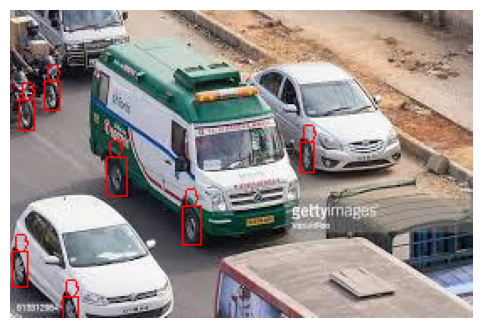

In [34]:
image_path = "/home/andrey/projects/data/wheel_detector/raw/023948023984.v1i.yolov11/train/images/804-Indian-Ambulance-Photos-and-Premium-High-Res_yy_jpg.rf.787ddc9354b99ff1214b785f29dc8dea.jpg"  # Replace with your image path
annotation_path = "/home/andrey/projects/data/wheel_detector/raw/023948023984.v1i.yolov11/train/labels_filtered/804-Indian-Ambulance-Photos-and-Premium-High-Res_yy_jpg.rf.787ddc9354b99ff1214b785f29dc8dea.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=0) 

In [35]:
input_directory = "/home/andrey/projects/data/wheel_detector/raw/023948023984.v1i.yolov11/train/labels"  # Replace with your annotations directory
output_directory = "/home/andrey/projects/data/wheel_detector/raw/023948023984.v1i.yolov11/train/labels_filtered"  # Replace with desired output directory
target_labels = [3]  # Replace with your target label indices

# Filter annotations
filter_annotations(input_directory, output_directory, target_labels) 

In [40]:
!cp -r "../raw/023948023984.v1i.yolov11/valid/labels_filtered" "../processed/yolo-dataset/labels/val/023948023984.v1i"

In [42]:
!cp -r "../raw/023948023984.v1i.yolov11/train/images" "../processed/yolo-dataset/images/train/023948023984.v1i"

# Axle Counter.v2i.yolov11 ⛔

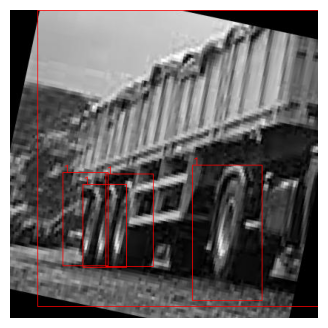

In [50]:
name = 'download--13-_jpg.rf.095eacdb0887c5859f3695ed1e5f45d3'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/Axle Counter.v2i.yolov11/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/Axle Counter.v2i.yolov11/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=None) 

In [35]:
input_directory = "/home/andrey/projects/data/wheel_detector/raw/023948023984.v1i.yolov11/train/labels"  # Replace with your annotations directory
output_directory = "/home/andrey/projects/data/wheel_detector/raw/023948023984.v1i.yolov11/train/labels_filtered"  # Replace with desired output directory
target_labels = [3]  # Replace with your target label indices

# Filter annotations
filter_annotations(input_directory, output_directory, target_labels) 

In [40]:
!cp -r "../raw/023948023984.v1i.yolov11/valid/labels_filtered" "../processed/yolo-dataset/labels/val/023948023984.v1i"

In [42]:
!cp -r "../raw/023948023984.v1i.yolov11/train/images" "../processed/yolo-dataset/images/train/023948023984.v1i"

# bus.v3i

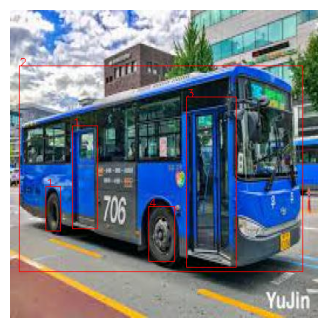

In [84]:
name = 'images--3-_jpg.rf.fe7e5c286ccdcb8241399fca0fc8752d'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/bus.v3i.yolov11/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/bus.v3i.yolov11/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=None) 

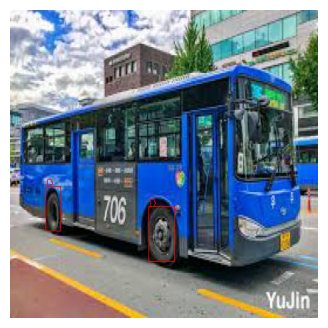

In [83]:
name = 'images--3-_jpg.rf.fe7e5c286ccdcb8241399fca0fc8752d'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/bus.v3i/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/bus.v3i/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [81]:
ds_name = 'bus.v3i.yolov11'
target_labels = [1, 4] 
for subset in ['train', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{'val' if subset in ['valid', 'test'] else subset}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{'val' if subset in ['valid','test'] else subset}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

/home/andrey/projects/data/wheel_detector/raw/bus.v3i.yolov11/train/labels/NaverBlog_20201129_214603_14_jpg.rf.66af49bdf3bf494b534fa44b647a2ed4.txt
/home/andrey/projects/data/wheel_detector/raw/bus.v3i.yolov11/train/labels/images--3-_jpg.rf.fe7e5c286ccdcb8241399fca0fc8752d.txt


# Car Components Dataset.v11-remapped-gen-classes-add-door-aug-7x

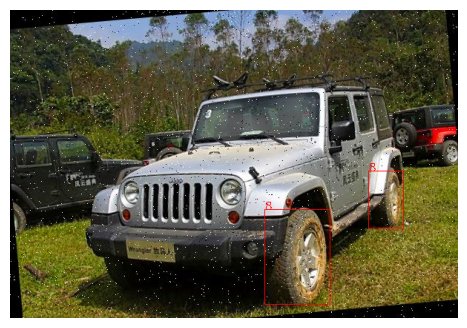

In [90]:
name = '2415d86fedd785_jpg.rf.f03ee4f641b9b084748df1b0033a0e47'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/Car-Components-Dataset.v11-remapped-gen-classes-add-door-aug-7x.yolov11/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/Car-Components-Dataset.v11-remapped-gen-classes-add-door-aug-7x.yolov11/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[8]) 

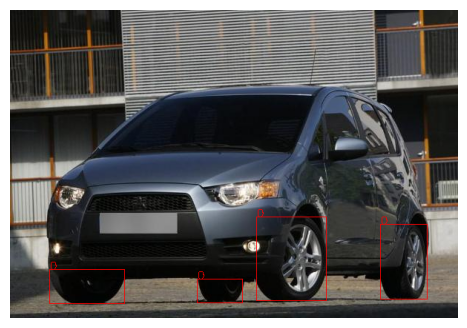

In [92]:
name = '443935c315c4cc_jpg.rf.9dc363a983d9586ffd4e7e77fd1fc51c'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/val/Car-Components-Dataset.v11-remapped-gen-classes-add-door-aug-7x/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/val/Car-Components-Dataset.v11-remapped-gen-classes-add-door-aug-7x/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [ ]:
ds_name = 'Car-Components-Dataset.v11-remapped-gen-classes-add-door-aug-7x.yolov11'
target_labels = [8] 
for subset in ['train', 'val', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{'val' if subset in ['valid', 'test'] else subset}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{'val' if subset in ['valid','test'] else subset}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# car_components_segmentation_2.v6i.yolov11

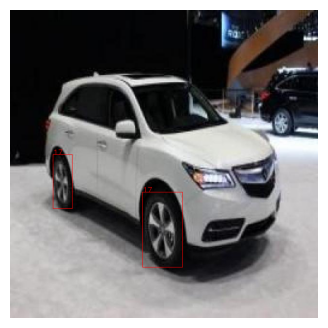

In [116]:
name = '01GSA6RM1038PH9TWY7E4EGDNA_jpeg_jpg.rf.e782a828d94f05a0c0bfcdce7cc1480d'
ds_name = 'car_components_segmentation_2.v6i.yolov11'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[17]) 

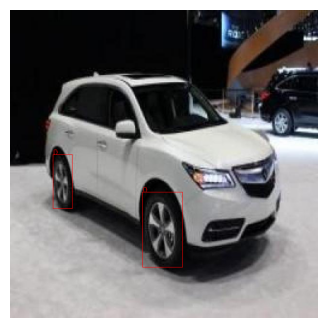

In [149]:
name = '01GSA6RM1038PH9TWY7E4EGDNA_jpeg_jpg.rf.e782a828d94f05a0c0bfcdce7cc1480d'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [148]:

target_labels = [17] 
for subset in ['train', 'valid', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{'val' if subset in ['valid', 'test'] else subset}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{'val' if subset in ['valid','test'] else subset}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# Car-Part-Detection-with-Damage-Part.v2-analysis-ready.yolov11

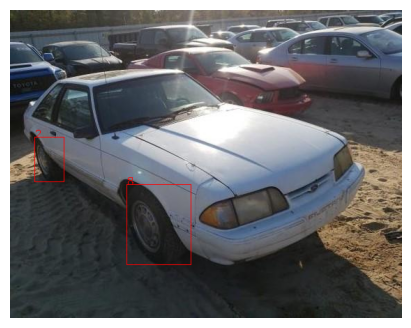

In [150]:
name = 'Car-damages-2_jpg.rf.b537a3354f429f04c9fbb9d9b3ff5bf6'
ds_name = 'Car-Part-Detection-with-Damage-Part.v2-analysis-ready.yolov11'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[2,8]) 

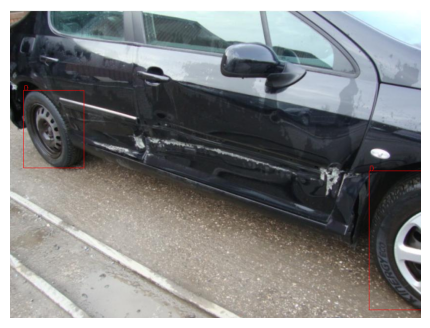

In [157]:
name = 'Car-damages-1672_png.rf.1bedea70272a8034ec8a74eaade12e82'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [151]:

target_labels = [2,8]
subset_mapping = {
    'train': 'train',
    'test': 'train',
    'valid': 'val',
}
for subset in ['train', 'valid', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# Cart parts.v2i.yolov11 ⛔

In [218]:


def filter_annotations_Cart_partsv2(input_dir, output_dir, target_labels, file_extension='.txt'):
    """
    Filter YOLO annotation files by keeping only specified target labels.
    
    Args:
        input_dir (str): Path to directory containing annotation files
        output_dir (str): Path to directory where filtered annotations will be saved
        target_labels (list): List of label indices to keep
        file_extension (str): Extension of annotation files (default: '.txt')
    """
    # Create output directory if it doesn't exist
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Convert target labels to set for faster lookup
    target_labels = set(target_labels)
    
    # Counter for statistics
    total_files = 0
    total_boxes = 0
    kept_boxes = 0
    
    # Process each annotation file
    for ann_file in Path(input_dir).glob(f'*{file_extension}'):
        filtered_annotations = []
        
        # Read annotations
        with ann_file.open('r') as f:
            annotations = f.readlines()
        
        # Filter annotations
        no_save = False
        for ann in annotations:
            try:
                label, *box = map(float, ann.strip().split())
                label = int(label)
                if label in target_labels:
                    if len(box) != 4:
                        box = np.array(box).reshape((-1,2))
                        x_min, y_min = box.min(axis=0)
                        x_max, y_max = box.max(axis=0)
                        x_center = x_min + (x_max - x_min) / 2
                        y_center = y_min + (y_max - y_min) / 2
                        width = x_max - x_min
                        height = y_max - y_min
                        ann_new = ' '.join(['0', str(x_center), str(y_center), str(width), str(height)]) + '\n'
                    else:
                        ann_new = '0 ' + ann.split(sep=' ', maxsplit=1)[-1]
                    if 0.15 <=float(ann_new.split()[-2]) <=0.2:
                        print(ann_file, ann_new[:-1])
                        # ann_file.unlink()
                        # Path(ann_file.parents[1], 'images', ann_file.with_suffix('.jpg').name).unlink()
                        # no_save = True
                        # break
                    filtered_annotations.append(ann_new)
                    kept_boxes += 1
                total_boxes += 1
            except (ValueError, IndexError) as e:
                print(f"Warning: Skipping invalid line in {ann_file}")
                print(e)
                continue
        
        # Save filtered annotations
        if not no_save:
            output_file = output_dir / ann_file.name
            output_file.write_text(''.join(filtered_annotations))
        
        total_files += 1


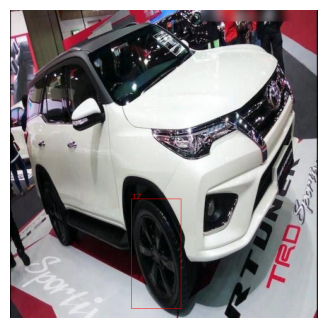

In [222]:
name = 'train22_jpg.rf.3fa3cf9ee11ed2662c4324ee4af18732'
ds_name = 'Cart parts.v2i.yolov11'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[17]) 

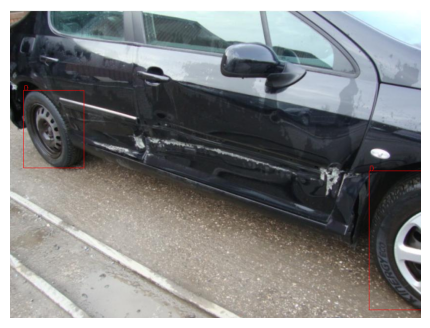

In [157]:
name = 'Car-damages-1672_png.rf.1bedea70272a8034ec8a74eaade12e82'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [219]:

target_labels = [17]
subset_mapping = {
    'train': 'train',
    'test': 'train',
    'valid': 'val',
}
for subset in ['train', 'valid', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations_Cart_partsv2(input_directory, output_directory, target_labels) 
    # src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    # dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    # !mkdir -p {dst}
    # !cp -r  {src} {dst}
    # src = f"../raw/{ds_name}/{subset}/images/*"
    # dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    # !mkdir -p {dst}
    # !cp -r  {src} {dst}

/home/andrey/projects/data/wheel_detector/raw/Cart parts.v2i.yolov11/train/labels/train95_jpg.rf.2eab83229cf71f4ad74e85291f48fcca.txt 0 0.5802734375 0.68955078125 0.17499999999999993 0.38339843749999997
/home/andrey/projects/data/wheel_detector/raw/Cart parts.v2i.yolov11/train/labels/train267_jpg.rf.a218629d8a8ba3a2e3346a2d0d70bf62.txt 0 0.8654296875 0.9046875 0.16914062499999993 0.11445312500000004
/home/andrey/projects/data/wheel_detector/raw/Cart parts.v2i.yolov11/train/labels/train275_jpg.rf.3c37ac810430b60edce69fd708267492.txt 0 0.64921875 0.756640625 0.15742187499999993 0.35273437499999993
/home/andrey/projects/data/wheel_detector/raw/Cart parts.v2i.yolov11/train/labels/train278_jpg.rf.af7f0ea23a20ab0fcb37c8ad8158766d.txt 0 0.53818359375 0.705859375 0.1697265625 0.25507812499999993
/home/andrey/projects/data/wheel_detector/raw/Cart parts.v2i.yolov11/train/labels/train14_jpg.rf.721f179fad7fe4a5a7dd421f5f20a8dd.txt 0 0.38408203125 0.79658203125 0.16855468750000002 0.263476562500000

# EixosDeCaminhao.v2i.yolov11

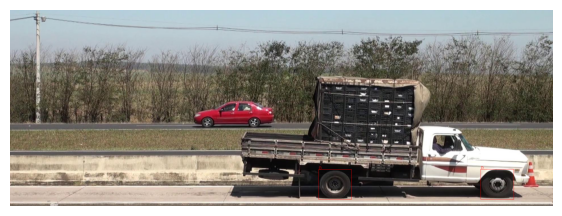

In [227]:
name = '20160927110318-550_color-ROI-1-30_jpg.rf.6a3963bdd3a61520ab27f562e43b4490'
ds_name = 'EixosDeCaminhao.v2i.yolov11'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

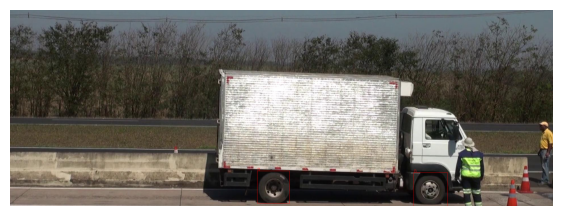

In [229]:
name = '20160927100754-550_color-ROI-1-8_jpg.rf.f4e1a4dff4e5d5a462b4a10f3a97316c'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [228]:

target_labels = [0]
subset_mapping = {
    'train': 'train',
    'test': 'val',
    'valid': 'val',
}
for subset in ['train', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# Heavy vehicle detection -NHAI 2.0.v13i.yolov11 ⛔

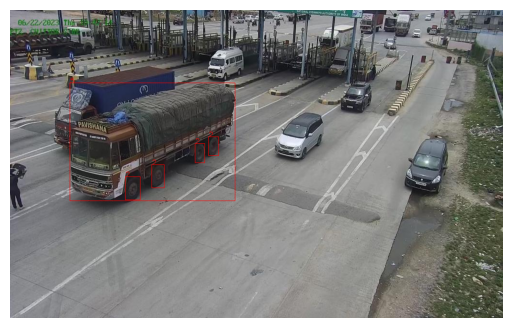

In [231]:
name = 'iftekhar-2_192_jpg.rf.27a8862409bbf7d98555c6edc6fea47f'
ds_name = 'Heavy vehicle detection -NHAI 2.0.v13i.yolov11'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=None) 

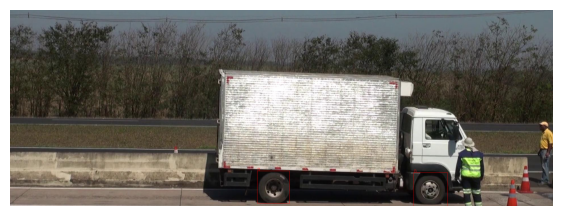

In [229]:
name = '20160927100754-550_color-ROI-1-8_jpg.rf.f4e1a4dff4e5d5a462b4a10f3a97316c'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [228]:

target_labels = [0]
subset_mapping = {
    'train': 'train',
    'test': 'val',
    'valid': 'val',
}
for subset in ['train', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# Heavy Vehicle Detection - NHAI Interns.v21i.yolov11 ⛔

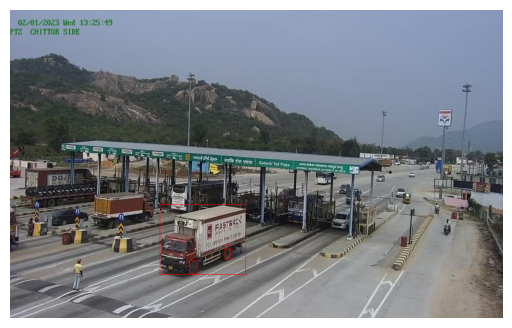

In [233]:
name = '2023-06-03-01_09_27-446648__00000001-another-copy-_jpg.rf.7bda3889f7b95e547de66e7c7a008902'
ds_name = 'Heavy Vehicle Detection - NHAI Interns.v21i.yolov11'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=None) 

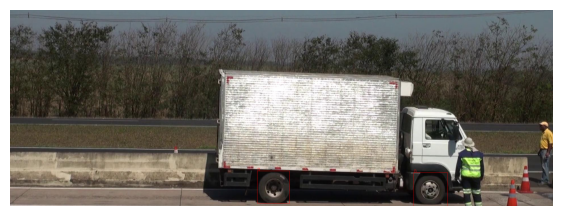

In [229]:
name = '20160927100754-550_color-ROI-1-8_jpg.rf.f4e1a4dff4e5d5a462b4a10f3a97316c'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [228]:

target_labels = [0]
subset_mapping = {
    'train': 'train',
    'test': 'val',
    'valid': 'val',
}
for subset in ['train', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# Vehicle Axle.v11i.yolov11 ⛔

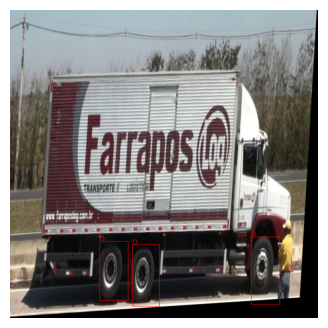

In [236]:
name = '20160927111324-550_color-ROI-1-20_jpg.rf.d277d3ab9662ee2a030f698deec45722'
ds_name = 'Vehicle Axle.v11i.yolov11'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=None) 

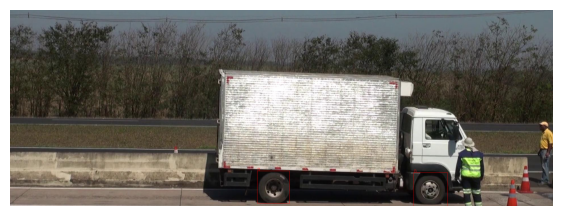

In [229]:
name = '20160927100754-550_color-ROI-1-8_jpg.rf.f4e1a4dff4e5d5a462b4a10f3a97316c'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [228]:

target_labels = [0]
subset_mapping = {
    'train': 'train',
    'test': 'val',
    'valid': 'val',
}
for subset in ['train', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# Vehicle wheel detection.v1-axle-detecion.yolov11

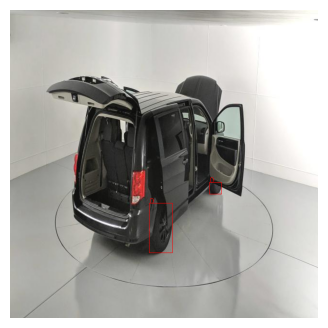

In [241]:
name = '2C4RDGBG3KR504548-2019-Dodge-GrandCaravan-sp_turntable_pic-2512-16x9-3840x2160-4K-20211122171119-_jpg.rf.850a7b60a2fd7f02d0fb31800378d598'
ds_name = 'Vehicle-wheel-detection.v1-axle-detecion.yolov11'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=None) 

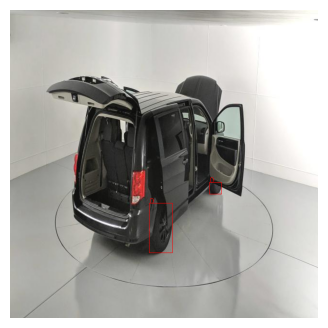

In [244]:
name = '2C4RDGBG3KR504548-2019-Dodge-GrandCaravan-sp_turntable_pic-2512-16x9-3840x2160-4K-20211122171119-_jpg.rf.850a7b60a2fd7f02d0fb31800378d598'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [243]:

target_labels = [0]
subset_mapping = {
    'train': 'train',
    'test': 'train',
    'valid': 'val',
}
for subset in ['train', 'valid', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# wheel-detector

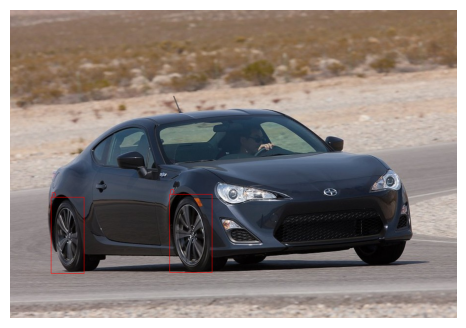

In [248]:
name = '5f11f734c45dd5'
ds_name = 'wheel-detector'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=None) 

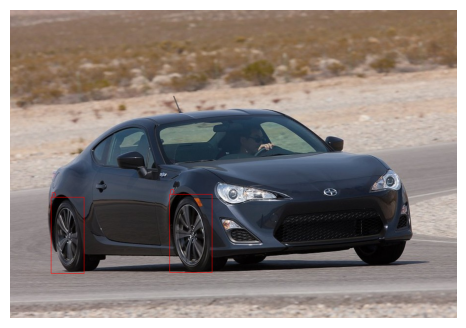

In [250]:
name = '5f11f734c45dd5'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [249]:

target_labels = [0]
subset_mapping = {
    'train': 'train',
    'test': 'train',
    'valid': 'val',
}
for subset in ['train']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# wheels-detection-vuaey

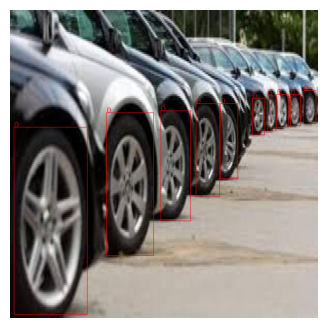

In [251]:
name = 'download-1-_jpeg.rf.a8a956bc3a6abd1128b94b9dd46d73ad'
ds_name = 'wheels-detection-vuaey'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=None) 

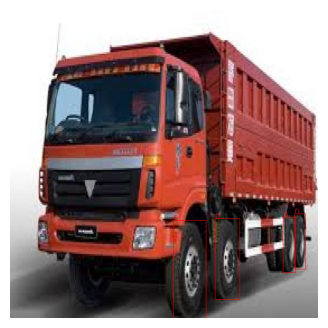

In [254]:
name = 'download-5-_jpeg.rf.62f335566df4d6de17936ff836d93edb'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0]) 

In [252]:
target_labels = [0]
subset_mapping = {
    'train': 'train',
    'test': 'train',
    'valid': 'val',
}
for subset in ['train', 'valid', 'test']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}

# Vehicle Wheel Detection | Axle Detection

In [256]:
from pathlib import Path


class XMLToYOLOConverter:
    def __init__(self, class_mapping: Dict[str, int] = None):
        """
        Initialize converter with optional class mapping
        Args:
            class_mapping: Dictionary mapping class names to YOLO label indices
                         If None, will create mapping automatically
        """
        self.class_mapping = class_mapping
        self.classes_found = set()

    def convert_coordinates(self, size: Tuple[int, int], box: Tuple[int, int, int, int]) -> Tuple[float, float, float, float]:
        """
        Convert Pascal VOC coordinates to YOLO format
        Args:
            size: Tuple of (width, height) of the image
            box: Tuple of (xmin, ymin, xmax, ymax)
        Returns:
            Tuple of (x_center, y_center, width, height) normalized between 0 and 1
        """
        dw = 1.0 / size[0]
        dh = 1.0 / size[1]
        
        # Extract coordinates
        xmin, ymin, xmax, ymax = box
        
        # Calculate YOLO coordinates
        x_center = (xmin + xmax) / 2.0
        y_center = (ymin + ymax) / 2.0
        w = xmax - xmin
        h = ymax - ymin
        
        # Normalize
        x_center *= dw
        y_center *= dh
        w *= dw
        h *= dh
        
        return (x_center, y_center, w, h)

    def parse_xml(self, xml_path: Path) -> List[str]:
        """
        Parse XML file and convert annotations to YOLO format
        Args:
            xml_path: Path to XML file
        Returns:
            List of YOLO format annotations (one string per object)
        """
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Get image size
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        yolo_annotations = []
        
        # Process each object
        for obj in root.findall('object'):
            name = obj.find('name').text
            self.classes_found.add(name)
            
            # If no class mapping provided, create one automatically
            if self.class_mapping is None:
                self.class_mapping = {cls: idx for idx, cls in enumerate(sorted(self.classes_found))}
            
            # Get class index
            class_idx = self.class_mapping.get(name)
            if class_idx is None:
                print(f"Warning: Class '{name}' not found in mapping, skipping")
                continue
            
            # Get bounding box coordinates
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            
            # Convert to YOLO format
            x_center, y_center, w, h = self.convert_coordinates(
                (width, height), 
                (xmin, ymin, xmax, ymax)
            )
            
            # Create YOLO format string
            yolo_ann = f"{class_idx} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n"
            yolo_annotations.append(yolo_ann)
        
        return yolo_annotations

    def convert_directory(self, input_dir: Path, output_dir: Path):
        """
        Convert all XML files in directory to YOLO format
        Args:
            input_dir: Directory containing XML files
            output_dir: Directory to save YOLO format files
        """
        input_dir = Path(input_dir)
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Process all XML files
        xml_files = list(input_dir.glob('*.xml'))
        total_files = len(xml_files)
        
        print(f"Found {total_files} XML files to process")
        
        for i, xml_file in enumerate(xml_files, 1):
            # Convert annotations
            yolo_annotations = self.parse_xml(xml_file)
            
            # Save to output file
            output_file = output_dir / f"{xml_file.stem}.txt"
            output_file.write_text(''.join(yolo_annotations))
            
            # Progress update
            if i % 100 == 0:
                print(f"Processed {i}/{total_files} files")
        
        # Save class mapping
        if self.class_mapping:
            classes_file = output_dir / "classes.txt"
            class_names = sorted(self.class_mapping.keys(), key=lambda x: self.class_mapping[x])
            classes_file.write_text('\n'.join(class_names))
            

input_directory = "/home/andrey/projects/data/wheel_detector/raw/Vehicle-Wheel-Detection-Axle-Detection/train/labels"  # Replace with your XML directory
output_directory = "/home/andrey/projects/data/wheel_detector/raw/Vehicle-Wheel-Detection-Axle-Detection/train/labels_filtered"  # Replace with desired output directory

# Optional: Define your own class mapping
class_mapping = {
    "wheel": 0,
    # Add more classes as needed
}

# Initialize converter (with or without class mapping)
converter = XMLToYOLOConverter(class_mapping)  # With mapping
# converter = XMLToYOLOConverter()  # Without mapping (will create automatically)

# Convert all files in directory
converter.convert_directory(input_directory, output_directory) 

Found 676 XML files to process
Processed 100/676 files
Processed 200/676 files
Processed 300/676 files
Processed 400/676 files
Processed 500/676 files
Processed 600/676 files


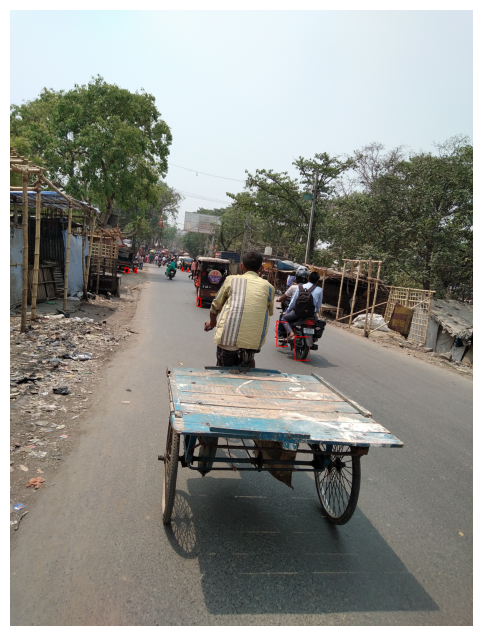

In [266]:
name = '20210416_10_44_00_000_3Iav7BUguBPjLs3z0JBE5mqCPG82_F_3120_4160'
ds_name = 'Vehicle-Wheel-Detection-Axle-Detection'
image_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/images/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/train/labels_filtered/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0], figsize=(12,8), line_width=3) 

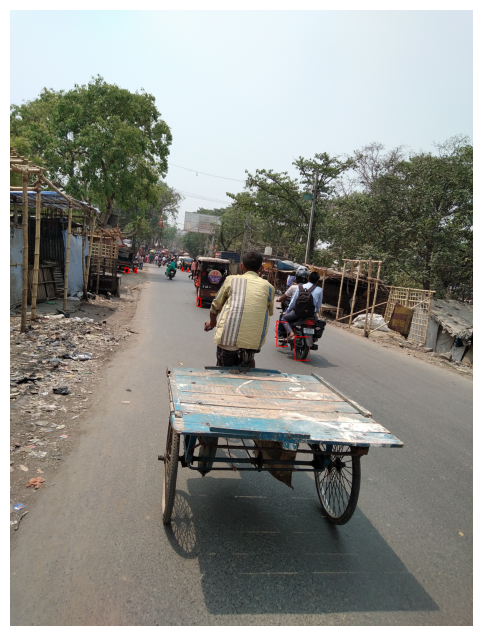

In [269]:
name = '20210416_10_44_00_000_3Iav7BUguBPjLs3z0JBE5mqCPG82_F_3120_4160'
image_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/images/train/{ds_name.replace('.yolov11', '')}/{name}.jpg"  # Replace with your image path
annotation_path = f"/home/andrey/projects/data/wheel_detector/processed/yolo-dataset/labels/train/{ds_name.replace('.yolov11', '')}/{name}.txt"  # Replace with your annotation file path
visualize_annotations(image_path, annotation_path, target_class=[0], figsize=(12,8), line_width=3) 

In [267]:
target_labels = [0]
subset_mapping = {
    'train': 'train',
    'test': 'train',
    'valid': 'val',
}
for subset in ['train']:
    input_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels"  # Replace with your annotations directory
    output_directory = f"/home/andrey/projects/data/wheel_detector/raw/{ds_name}/{subset}/labels_filtered"  # Replace with desired output directory
     # Replace with your target label indices
    
    # Filter annotations
    filter_annotations(input_directory, output_directory, target_labels) 
    src = f"../raw/{ds_name}/{subset}/labels_filtered/*"
    dst = f"../processed/yolo-dataset/labels/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}
    src = f"../raw/{ds_name}/{subset}/images/*"
    dst = f"../processed/yolo-dataset/images/{subset_mapping[subset]}/{ds_name.replace('.yolov11', '')}"
    !mkdir -p {dst}
    !cp -r  {src} {dst}